# ADS GAN for MIMIC

**Setup and Data Download**

In this section, we import the necessary libraries, authenticate with Google Cloud to access the data, and download the required datasets from Google Cloud Storage. We also prepare the data directory for further processing.

In [1]:
# Standard Libraries
import os
import gc
import random
# Data Manipulation
import pandas as pd
import numpy as np
# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, TensorDataset
from torch.utils.data._utils.collate import default_collate
# Scikit-learn
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
# Statistics
from scipy.stats import ks_2samp, chi2_contingency
from scipy.spatial.distance import jensenshannon
# Progress Bar
from tqdm.notebook import tqdm
# Image Handling
from imageio.v2 import imread
from PIL import Image
# Google Colab Authentication
from google.colab import auth
# Torchvision
from torchvision import models, transforms

# Authenticate with Google Cloud
auth.authenticate_user()

# Create the destination folder
!mkdir -p ./hosp

# Copy all files except labevents.csv.gz from Google Cloud Storage
!gcloud storage cp -r gs://all_data_mlhc/mimic-iv-3.0/hosp ./hosp
!rm ./hosp/hosp/labevents.csv.gz

# Decompress all .csv.gz files except labevents.csv.gz
!find ./hosp -name "*.csv.gz" -not -name "labevents.csv.gz" -exec gunzip {} +


Copying gs://all_data_mlhc/mimic-iv-3.0/hosp/admissions.csv.gz to file://./hosp/hosp/admissions.csv.gz
Copying gs://all_data_mlhc/mimic-iv-3.0/hosp/d_hcpcs.csv.gz to file://./hosp/hosp/d_hcpcs.csv.gz
Copying gs://all_data_mlhc/mimic-iv-3.0/hosp/d_icd_diagnoses.csv.gz to file://./hosp/hosp/d_icd_diagnoses.csv.gz
Copying gs://all_data_mlhc/mimic-iv-3.0/hosp/d_icd_procedures.csv.gz to file://./hosp/hosp/d_icd_procedures.csv.gz
Copying gs://all_data_mlhc/mimic-iv-3.0/hosp/d_labitems.csv.gz to file://./hosp/hosp/d_labitems.csv.gz
Copying gs://all_data_mlhc/mimic-iv-3.0/hosp/diagnoses_icd.csv.gz to file://./hosp/hosp/diagnoses_icd.csv.gz
Copying gs://all_data_mlhc/mimic-iv-3.0/hosp/drgcodes.csv.gz to file://./hosp/hosp/drgcodes.csv.gz
Copying gs://all_data_mlhc/mimic-iv-3.0/hosp/emar.csv.gz to file://./hosp/hosp/emar.csv.gz
Copying gs://all_data_mlhc/mimic-iv-3.0/hosp/emar_detail.csv.gz to file://./hosp/hosp/emar_detail.csv.gz
Copying gs://all_data_mlhc/mimic-iv-3.0/hosp/hcpcsevents.csv.gz t

**Data Preprocessing**

Here, we load the admissions and patients data, sample a subset of patients, and preprocess the data by normalizing continuous variables and one-hot encoding categorical variables. We also aggregate diagnoses, procedures, and medications data to prepare the final dataset for training.

In [2]:
data_dir = './hosp'
sub_dir = os.path.join(data_dir, 'hosp')

admissions_path = os.path.join(sub_dir, 'admissions.csv')
admissions = pd.read_csv(
    admissions_path,
    usecols=['subject_id', 'admittime', 'dischtime', 'insurance', 'language', 'marital_status', 'race'],
    parse_dates=['admittime', 'dischtime']
)

patients_path = os.path.join(sub_dir, 'patients.csv')
patients = pd.read_csv(
    patients_path,
    usecols=['subject_id', 'gender', 'anchor_age']
)

unique_subject_ids = admissions['subject_id'].unique()
sampled_subject_ids = (
    np.random.choice(unique_subject_ids, size=50000, replace=False)
    if len(unique_subject_ids) > 50000 else unique_subject_ids
)

admissions = admissions[admissions['subject_id'].isin(sampled_subject_ids)]
patients = patients[patients['subject_id'].isin(sampled_subject_ids)]

del unique_subject_ids
gc.collect()

admissions['length_of_stay'] = (admissions['dischtime'] - admissions['admittime']).dt.days

if not admissions['length_of_stay'].isna().all():
    scaler = MinMaxScaler()
    admissions['length_of_stay'] = scaler.fit_transform(admissions[['length_of_stay']])
else:
    admissions['length_of_stay'] = pd.Series(dtype='float64')

categorical_cols = ['insurance', 'language', 'marital_status', 'race']
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoded_categorical = pd.DataFrame(
    encoder.fit_transform(admissions[categorical_cols]),
    columns=encoder.get_feature_names_out(categorical_cols)
)
encoded_categorical['subject_id'] = admissions['subject_id'].reset_index(drop=True)

categorical_sizes = [len(categories) for categories in encoder.categories_]
categorical_sizes_dict = dict(zip(categorical_cols, categorical_sizes))

patients['gender'] = patients['gender'].map({'M': 1, 'F': 0})
scaler_age = MinMaxScaler()
patients['anchor_age'] = scaler_age.fit_transform(patients[['anchor_age']])

admissions_processed = admissions[['subject_id', 'length_of_stay']].merge(
    encoded_categorical, on='subject_id', how='left'
)
data = admissions_processed.merge(patients, on='subject_id', how='left')

def process_table_in_chunks(file_path, key_col, value_col, sampled_subject_ids, top_n=50):
    value_counts = {}
    chunks = pd.read_csv(file_path, usecols=[key_col, value_col], chunksize=500000)
    for chunk in chunks:
        chunk = chunk[chunk[key_col].isin(sampled_subject_ids)].dropna(subset=[value_col])
        counts = chunk[value_col].value_counts()
        for val, count in counts.items():
            value_counts[val] = value_counts.get(val, 0) + count
        del chunk
        gc.collect()
    top_values = pd.Series(value_counts).nlargest(top_n).index.tolist()
    del value_counts
    gc.collect()

    aggregated_data = []
    chunks = pd.read_csv(file_path, usecols=[key_col, value_col], chunksize=500000)
    for chunk in chunks:
        chunk = chunk[chunk[key_col].isin(sampled_subject_ids) & chunk[value_col].isin(top_values)]
        if not chunk.empty:
            chunk = chunk.pivot_table(index=key_col, columns=value_col, aggfunc='size', fill_value=0)
            if isinstance(chunk.columns, pd.MultiIndex):
                chunk.columns = ['_'.join(col).strip() for col in chunk.columns.values]
            chunk.reset_index(inplace=True)
            aggregated_data.append(chunk)
        del chunk
        gc.collect()
    return pd.concat(aggregated_data, axis=0) if aggregated_data else pd.DataFrame()

diagnoses_path = os.path.join(sub_dir, 'diagnoses_icd.csv')
procedures_path = os.path.join(sub_dir, 'procedures_icd.csv')
medications_path = os.path.join(sub_dir, 'emar.csv')

diagnoses_agg = process_table_in_chunks(
    diagnoses_path, 'subject_id', 'icd_code', sampled_subject_ids, top_n=50
)
procedures_agg = process_table_in_chunks(
    procedures_path, 'subject_id', 'icd_code', sampled_subject_ids, top_n=50
)
medications_agg = process_table_in_chunks(
    medications_path, 'subject_id', 'medication', sampled_subject_ids, top_n=50
)

for agg in [diagnoses_agg, procedures_agg, medications_agg]:
    if not agg.empty:
        data = data.merge(agg, on='subject_id', how='left').fillna(0)
        del agg
        gc.collect()

continuous_cols = ['length_of_stay', 'anchor_age']
binary_cols = ['gender']
one_hot_cols = encoded_categorical.columns.drop('subject_id').tolist()
categorical_cols_final = binary_cols + one_hot_cols
count_cols = data.columns.difference(['subject_id'] + continuous_cols + categorical_cols_final)

agg_dict = {col: 'mean' if col in continuous_cols else 'max' for col in data.columns if col != 'subject_id'}
data = data.groupby('subject_id').agg(agg_dict).reset_index()

for col in data.columns:
    if data[col].dtype == 'float64':
        data[col] = data[col].astype('float32')
    elif data[col].dtype == 'int64':
        data[col] = data[col].astype('int32')

categorical_cols_final += count_cols.tolist()

data_tensor = torch.tensor(data.drop('subject_id', axis=1).values, dtype=torch.float32)

print("done")

done


**Define the ADS-GAN Model**

We define the Generator and Discriminator neural network architectures for the ADS-GAN model. The Generator produces synthetic data given random noise, while the Discriminator evaluates the authenticity of the data.

In [3]:
class Generator(nn.Module):
    def __init__(self, input_dim, continuous_dim, categorical_sizes):
        super(Generator, self).__init__()
        self.continuous_dim = continuous_dim
        self.categorical_sizes = categorical_sizes

        self.fc1 = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(512)
        )
        self.fc2 = nn.Sequential(
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(1024)
        )
        self.project_to_attention = nn.Linear(1024, 512)
        self.attention = nn.MultiheadAttention(embed_dim=512, num_heads=4, batch_first=True)
        self.fc3 = nn.Sequential(
            nn.Linear(512, 512),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(512)
        )
        self.fc_out = nn.Linear(512, continuous_dim + sum(categorical_sizes))

        self.init_weights()

    def init_weights(self):
        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.xavier_uniform_(module.weight)

    def forward(self, z):
        x = self.fc1(z)
        residual = x
        x = self.fc2(x)
        x = self.project_to_attention(x)
        x, _ = self.attention(x.unsqueeze(1), x.unsqueeze(1), x.unsqueeze(1))
        x = x.squeeze(1) + residual
        x = self.fc3(x)
        output = self.fc_out(x)

        continuous_output = torch.sigmoid(output[:, :self.continuous_dim])
        categorical_logits = output[:, self.continuous_dim:]
        split_logits = torch.split(categorical_logits, self.categorical_sizes, dim=1)
        return continuous_output, split_logits

class Discriminator(nn.Module):
    def __init__(self, feature_dim):
        super(Discriminator, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(feature_dim, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1)
        )
        self.init_weights()

    def init_weights(self):
        for layer in self.net:
            if isinstance(layer, nn.Linear):
                nn.init.xavier_uniform_(layer.weight)

    def forward(self, x):
        return self.net(x)


**Train the ADS-GAN Model**

We implement the training loop for the ADS-GAN model, including the gradient penalty for the Wasserstein loss function. We then initialize the models and train them using the prepared data.

Epoch 1/150 | Discriminator Loss: -0.2934, Generator Loss: -0.9261
Epoch 2/150 | Discriminator Loss: -1.3181, Generator Loss: -1.4676
Epoch 3/150 | Discriminator Loss: -2.5435, Generator Loss: -1.7841
Epoch 4/150 | Discriminator Loss: -3.9957, Generator Loss: -1.9452
Epoch 5/150 | Discriminator Loss: -5.5254, Generator Loss: -2.0407
Epoch 6/150 | Discriminator Loss: -7.0875, Generator Loss: -2.1292
Epoch 7/150 | Discriminator Loss: -8.6641, Generator Loss: -2.2235
Epoch 8/150 | Discriminator Loss: -10.1650, Generator Loss: -2.3769
Epoch 9/150 | Discriminator Loss: -11.6908, Generator Loss: -2.5404
Epoch 10/150 | Discriminator Loss: -13.2952, Generator Loss: -2.7158
Epoch 11/150 | Discriminator Loss: -14.7633, Generator Loss: -2.9077
Epoch 12/150 | Discriminator Loss: -16.2920, Generator Loss: -3.1353
Epoch 13/150 | Discriminator Loss: -17.7920, Generator Loss: -3.3556
Epoch 14/150 | Discriminator Loss: -19.4021, Generator Loss: -3.5857
Epoch 15/150 | Discriminator Loss: -20.9168, Gener

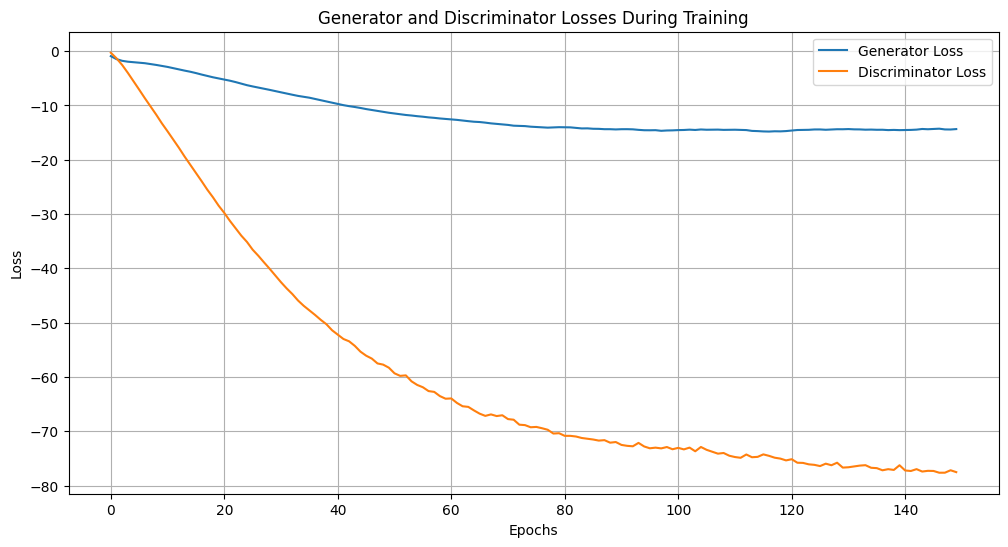

In [4]:
def gradient_penalty(discriminator, real_data, fake_data, lambda_gp=50):
    batch_size = real_data.size(0)
    alpha = torch.rand(batch_size, 1, device=real_data.device)
    alpha = alpha.expand_as(real_data)

    interpolated = alpha * real_data + (1 - alpha) * fake_data
    interpolated.requires_grad_(True)

    pred = discriminator(interpolated)

    gradients = torch.autograd.grad(
        outputs=pred,
        inputs=interpolated,
        grad_outputs=torch.ones_like(pred),
        create_graph=True,
        retain_graph=True,
    )[0]

    gradients = gradients.view(batch_size, -1)
    gradient_norm = gradients.norm(2, dim=1)

    return lambda_gp * ((gradient_norm - 1) ** 2).mean()

def train_ads_gan(
    generator, discriminator, data, continuous_dim, categorical_sizes,
    epochs=50, batch_size=1024, latent_dim=512,
    lambda_gp=5, n_critic=2, device="cuda", lr_gen=1e-3, lr_disc=1e-6, beta1=0.5, beta2=0.999
):
    generator = generator.to(device)
    discriminator = discriminator.to(device)

    gen_optimizer = optim.Adam(generator.parameters(), lr=lr_gen, betas=(beta1, beta2))
    disc_optimizer = optim.Adam(discriminator.parameters(), lr=lr_disc, betas=(beta1, beta2))

    indices = torch.randperm(data.size(0))
    data = data[indices]

    dataset = TensorDataset(data)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)

    g_losses = []
    d_losses = []

    for epoch in range(epochs):
        epoch_g_loss = 0
        epoch_d_loss = 0

        tau = 0.5  # Temperature parameter for Gumbel Softmax

        for batch_idx, real_batch in enumerate(dataloader):
            real_data = real_batch[0].to(device)

            # --------------------
            # Train Discriminator
            # --------------------
            for _ in range(n_critic):
                z = torch.randn(real_data.size(0), latent_dim, device=device)
                fake_continuous, fake_categorical_logits = generator(z)

                fake_categorical_samples = [F.gumbel_softmax(logits, tau=tau, hard=True) for logits in fake_categorical_logits]

                fake_data = torch.cat([fake_continuous] + fake_categorical_samples, dim=1)

                noisy_real_data = real_data + torch.normal(0, 0.05, size=real_data.shape, device=real_data.device)

                disc_real = discriminator(noisy_real_data).mean()
                disc_fake = discriminator(fake_data.detach()).mean()

                gp = gradient_penalty(discriminator, noisy_real_data, fake_data.detach(), lambda_gp)

                disc_loss = disc_fake - disc_real + gp

                disc_optimizer.zero_grad()
                disc_loss.backward()
                disc_optimizer.step()

                epoch_d_loss += disc_loss.item()

            # --------------------
            # Train Generator
            # --------------------
            z = torch.randn(batch_size, latent_dim, device=device)
            z = z + torch.normal(0, 0.2, size=z.shape, device=z.device)

            fake_continuous, fake_categorical_logits = generator(z)

            fake_categorical_samples = [F.gumbel_softmax(logits, tau=tau, hard=True) for logits in fake_categorical_logits]

            fake_data = torch.cat([fake_continuous] + fake_categorical_samples, dim=1)

            disc_fake = discriminator(fake_data).mean()
            generator_loss = -disc_fake

            real_categorical_probs = [
                real_data[:, sum(categorical_sizes[:i]):sum(categorical_sizes[:i+1])].mean(0)
                for i in range(len(categorical_sizes))
            ]
            fake_categorical_probs = [F.softmax(logits, dim=1).mean(0) for logits in fake_categorical_logits]
            loss_categorical = sum(
                F.cross_entropy(torch.log(fake + 1e-8), real) for fake, real in zip(fake_categorical_probs, real_categorical_probs)
            )

            diversity_loss = -torch.mean(torch.std(fake_continuous, dim=0))
            total_generator_loss = generator_loss + 0.5 * (2.0 * diversity_loss + loss_categorical)

            gen_optimizer.zero_grad()
            total_generator_loss.backward()

            torch.nn.utils.clip_grad_norm_(generator.parameters(), max_norm=1.0)

            gen_optimizer.step()

            epoch_g_loss += generator_loss.item()

        g_losses.append(epoch_g_loss / len(dataloader))
        d_losses.append(epoch_d_loss / (len(dataloader) * n_critic))

        # Log losses
        print(
            f"Epoch {epoch + 1}/{epochs} | Discriminator Loss: {d_losses[-1]:.4f}, "
            f"Generator Loss: {g_losses[-1]:.4f}"
        )

    return g_losses, d_losses

def set_seed(seed=42):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

continuous_cols = ['length_of_stay', 'anchor_age']
categorical_variables = ['insurance', 'language', 'marital_status', 'race']
categorical_sizes_list = [len(categories) for categories in encoder.categories_]
one_hot_cols = list(encoded_categorical.columns.drop('subject_id'))

count_cols = data.columns.difference(['subject_id'] + continuous_cols + one_hot_cols + ['gender']).tolist()

all_continuous_cols = continuous_cols + count_cols + ['gender']

data_features = data[['subject_id'] + all_continuous_cols + one_hot_cols]

expected_columns = set(all_continuous_cols + one_hot_cols)
all_columns = set(data_features.columns) - {'subject_id'}
unexpected_columns = all_columns - expected_columns
if unexpected_columns:
    data_features = data_features.drop(columns=unexpected_columns)

data_tensor = torch.tensor(data_features.drop(columns=['subject_id']).values, dtype=torch.float32)

continuous_dim = len(all_continuous_cols)
total_feature_dim = continuous_dim + sum(categorical_sizes_list)

latent_dim = 256
device = 'cuda' if torch.cuda.is_available() else 'cpu'

generator = Generator(
    input_dim=latent_dim,
    continuous_dim=continuous_dim,
    categorical_sizes=categorical_sizes_list
)
discriminator = Discriminator(feature_dim=total_feature_dim)

g_losses, d_losses = train_ads_gan(
    generator=generator,
    discriminator=discriminator,
    data=data_tensor,
    continuous_dim=continuous_dim,
    categorical_sizes=categorical_sizes_list,
    epochs=150,
    batch_size=1024,
    latent_dim=256,
    lambda_gp=5,
    n_critic=5,
    device=device,
    lr_gen=1e-3,
    lr_disc=1e-6,
    beta1=0.5,
    beta2=0.999
)

plt.figure(figsize=(12, 6))
plt.plot(g_losses, label="Generator Loss")
plt.plot(d_losses, label="Discriminator Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Generator and Discriminator Losses During Training")
plt.legend()
plt.grid(True)
plt.show()


**Evaluate the Model**

Finally, we generate synthetic data using the trained generator and evaluate the performance of the model by comparing the distributions of continuous and categorical variables between the real and synthetic datasets. We also assess the utility of the synthetic data by training a classifier to distinguish between real and synthetic data.

Evaluating Continuous Variables using KS Test:
length_of_stay: KS Statistic = 0.5979, p-value = 0.0000
  -> Significant difference detected in 'length_of_stay' distributions.

anchor_age: KS Statistic = 0.5914, p-value = 0.0000
  -> Significant difference detected in 'anchor_age' distributions.

0040: KS Statistic = 0.9738, p-value = 0.0000
  -> Significant difference detected in '0040' distributions.

0045: KS Statistic = 0.9834, p-value = 0.0000
  -> Significant difference detected in '0045' distributions.

0066: KS Statistic = 0.8180, p-value = 0.0000
  -> Significant difference detected in '0066' distributions.

009U3ZX: KS Statistic = 0.9734, p-value = 0.0000
  -> Significant difference detected in '009U3ZX' distributions.

02100Z9: KS Statistic = 0.9867, p-value = 0.0000
  -> Significant difference detected in '02100Z9' distributions.

02H633Z: KS Statistic = 0.9865, p-value = 0.0000
  -> Significant difference detected in '02H633Z' distributions.

02HV33Z: KS Statistic = 0.9501,

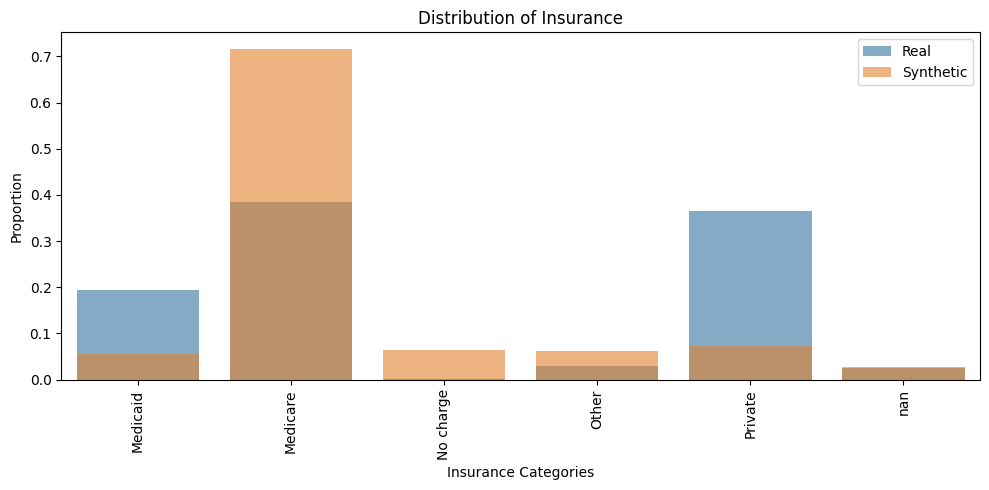

language:
  - Chi-squared statistic = 86708.6540, p-value = 0.0000
    -> Significant difference detected in 'language' distributions.
  - Jensen-Shannon Distance = 0.7488



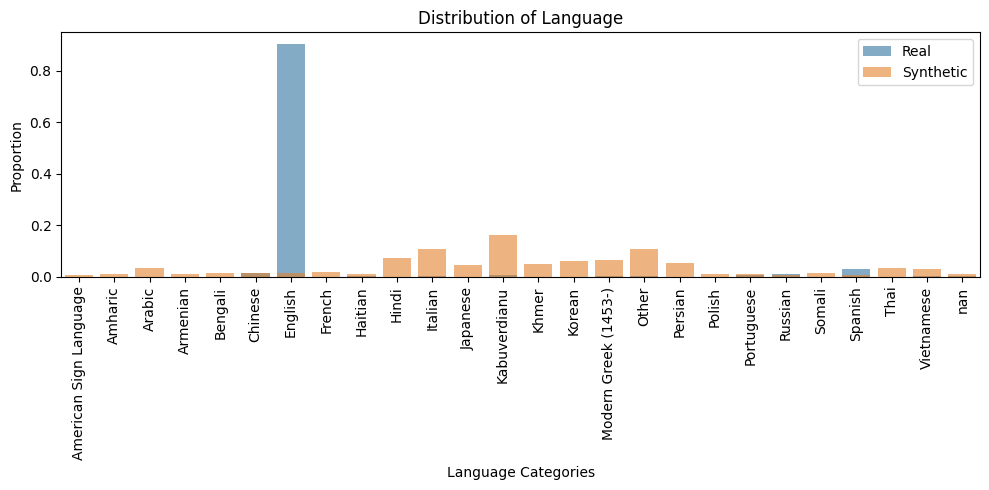

marital_status:
  - Chi-squared statistic = 16034.7792, p-value = 0.0000
    -> Significant difference detected in 'marital_status' distributions.
  - Jensen-Shannon Distance = 0.2887



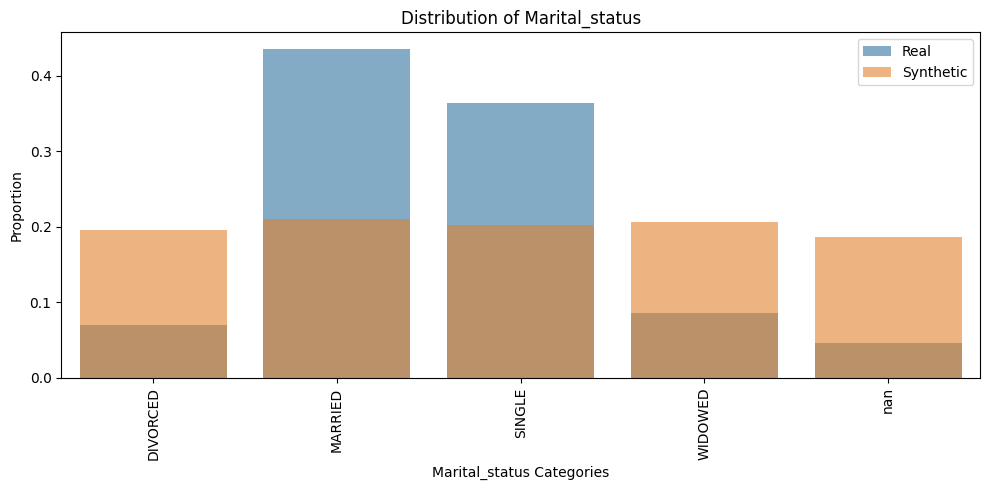

race:
  - Chi-squared statistic = 63351.1889, p-value = 0.0000
    -> Significant difference detected in 'race' distributions.
  - Jensen-Shannon Distance = 0.6284



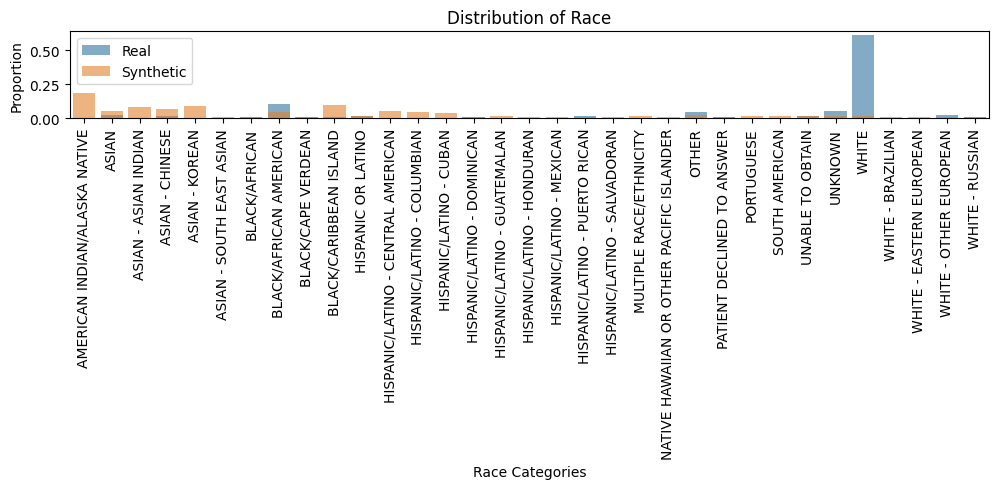

Classification Evaluation:
Classifier Accuracy (Distinguishing Real vs Synthetic): 1.0000
  -> Synthetic data may closely resemble real data. Consider enhancing privacy measures.


In [5]:
continuous_cols = all_continuous_cols
categorical_variables = ['insurance', 'language', 'marital_status', 'race']
categorical_sizes_list = [len(categories) for categories in encoder.categories_]
one_hot_cols = []
for i, variable in enumerate(categorical_variables):
    category_names = [f"{variable}_{category}" for category in encoder.categories_[i]]
    one_hot_cols.extend(category_names)

def generate_synthetic_data(generator, data_tensor, latent_dim, device, continuous_cols, categorical_variables, encoder):
    generator.eval()
    with torch.no_grad():
        z = torch.randn(data_tensor.size(0), latent_dim, device=device)
        synthetic_continuous, synthetic_categorical_logits = generator(z)
        synthetic_continuous = synthetic_continuous.cpu().numpy()
        synthetic_categorical_logits = [logits.cpu() for logits in synthetic_categorical_logits]

    tau = 0.2
    synthetic_categorical_samples = [
        F.gumbel_softmax(logits, tau=tau, hard=True).numpy()
        for logits in synthetic_categorical_logits
    ]

    synthetic_continuous_df = pd.DataFrame(synthetic_continuous, columns=continuous_cols)

    synthetic_categorical_dfs = []
    for i, variable in enumerate(categorical_variables):
        one_hot_samples = synthetic_categorical_samples[i]
        category_names = [f"{variable}_{category}" for category in encoder.categories_[i]]
        df = pd.DataFrame(one_hot_samples, columns=category_names)
        synthetic_categorical_dfs.append(df)

    synthetic_df = pd.concat([synthetic_continuous_df] + synthetic_categorical_dfs, axis=1)
    return synthetic_df

def preprocess_real_data(data, continuous_cols, one_hot_cols):
    data_features = data[continuous_cols + one_hot_cols].reset_index(drop=True)
    if data_features.columns.duplicated().any():
        data_features = data_features.loc[:, ~data_features.columns.duplicated()]
    return data_features

def reconstruct_categorical(df, categorical_variables, encoder):
    reconstructed = pd.DataFrame()
    for i, variable in enumerate(categorical_variables):
        category_names = [f"{variable}_{category}" for category in encoder.categories_[i]]
        cols = [col for col in df.columns if col in category_names]
        if cols:
            reconstructed[variable] = df[cols].idxmax(axis=1).str.replace(f'{variable}_', '', regex=True)
    return reconstructed

def evaluate_continuous(real_data, synthetic_data, continuous_columns):
    print("Evaluating Continuous Variables using KS Test:")
    for col in continuous_columns:
        real_values = real_data[col].values
        synthetic_values = synthetic_data[col].values
        stat, p_value = ks_2samp(real_values, synthetic_values)
        print(f"{col}: KS Statistic = {stat:.4f}, p-value = {p_value:.4f}")
        if p_value < 0.05:
            print(f"  -> Significant difference detected in '{col}' distributions.\n")
        else:
            print(f"  -> No significant difference detected in '{col}' distributions.\n")

def evaluate_categorical(real_data, synthetic_data, categorical_variables):
    print("\nEvaluating Categorical Variables using Chi-Squared Test and Jensen-Shannon Divergence:")
    for variable in categorical_variables:
        real_categories = real_data[variable]
        synthetic_categories = synthetic_data[variable]
        real_counts = real_categories.value_counts()
        synthetic_counts = synthetic_categories.value_counts()
        all_categories = real_counts.index.union(synthetic_counts.index)
        real_counts = real_counts.reindex(all_categories, fill_value=0)
        synthetic_counts = synthetic_counts.reindex(all_categories, fill_value=0)
        contingency_table = pd.DataFrame({
            'Real': real_counts,
            'Synthetic': synthetic_counts
        })
        chi2, p, dof, expected = chi2_contingency(contingency_table)
        print(f"{variable}:")
        print(f"  - Chi-squared statistic = {chi2:.4f}, p-value = {p:.4f}")
        if p < 0.05:
            print(f"    -> Significant difference detected in '{variable}' distributions.")
        else:
            print(f"    -> No significant difference detected in '{variable}' distributions.")
        real_prob = real_counts / real_counts.sum()
        synthetic_prob = synthetic_counts / synthetic_counts.sum()
        js_distance = jensenshannon(real_prob, synthetic_prob)
        print(f"  - Jensen-Shannon Distance = {js_distance:.4f}\n")
        plt.figure(figsize=(10, 5))
        sns.barplot(x=real_prob.index, y=real_prob.values, alpha=0.6, label='Real')
        sns.barplot(x=synthetic_prob.index, y=synthetic_prob.values, alpha=0.6, label='Synthetic')
        plt.title(f'Distribution of {variable.capitalize()}')
        plt.xlabel(f'{variable.capitalize()} Categories')
        plt.ylabel('Proportion')
        plt.legend()
        plt.xticks(rotation=90)
        plt.tight_layout()
        plt.show()

def classification_evaluation(real_data, synthetic_data):
    print("Classification Evaluation:")
    combined_data = pd.concat([real_data, synthetic_data], ignore_index=True)
    labels = np.array([1] * len(real_data) + [0] * len(synthetic_data))
    combined_data = combined_data.fillna(0)
    X_train, X_test, y_train, y_test = train_test_split(
        combined_data, labels, test_size=0.3, random_state=42, stratify=labels
    )
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"Classifier Accuracy (Distinguishing Real vs Synthetic): {acc:.4f}")
    if acc > 0.55:
        print("  -> Synthetic data may closely resemble real data. Consider enhancing privacy measures.")
    elif acc < 0.45:
        print("  -> Synthetic data differs significantly from real data. Consider improving data utility.")
    else:
        print("  -> Synthetic data maintains a good balance between privacy and utility.")

def execute_evaluation(generator, data_tensor, device, latent_dim, data, continuous_cols, categorical_variables, encoder):
    synthetic_df = generate_synthetic_data(
        generator, data_tensor, latent_dim, device,
        continuous_cols, categorical_variables, encoder
    )
    one_hot_cols = []
    for i, variable in enumerate(categorical_variables):
        category_names = [f"{variable}_{category}" for category in encoder.categories_[i]]
        one_hot_cols.extend(category_names)
    real_data_features = preprocess_real_data(data, continuous_cols, one_hot_cols)
    real_categorical_reconstructed = reconstruct_categorical(real_data_features, categorical_variables, encoder)
    synthetic_categorical_reconstructed = reconstruct_categorical(synthetic_df, categorical_variables, encoder)
    real_continuous = real_data_features[continuous_cols]
    synthetic_continuous = synthetic_df[continuous_cols]
    evaluate_continuous(real_continuous, synthetic_continuous, continuous_cols)
    evaluate_categorical(real_categorical_reconstructed, synthetic_categorical_reconstructed, categorical_variables)
    classification_evaluation(real_data_features, synthetic_df)

    # Return the dataframes for use outside the function
    return real_data_features, synthetic_df


generator = generator.to(device)
data_tensor = data_tensor.to(device)

real_data_features, synthetic_df = execute_evaluation(
    generator=generator,
    data_tensor=data_tensor,
    device=device,
    latent_dim=latent_dim,
    data=data,
    continuous_cols=continuous_cols,
    categorical_variables=categorical_variables,
    encoder=encoder
)



<ipython-input-6-99958d475918>:14: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(real_ages, label='Real', shade=True, color='mediumspringgreen')
<ipython-input-6-99958d475918>:15: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(synthetic_ages, label='Synthetic', shade=True, color='slateblue')


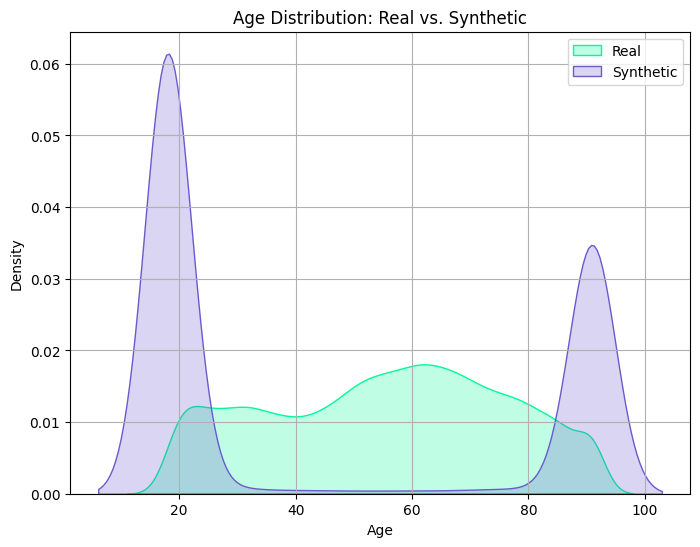

In [6]:
# For age comparison:
# If you scaled age before, you may want to inverse transform it to get actual ages.
# Assuming `patients['anchor_age']` was scaled, you can inverse_transform using `scaler_age`.
# If `scaler_age` is available:
real_ages_scaled = real_data_features['anchor_age']
synthetic_ages_scaled = synthetic_df['anchor_age']

real_ages = scaler_age.inverse_transform(real_ages_scaled.values.reshape(-1, 1)).flatten()
synthetic_ages = scaler_age.inverse_transform(synthetic_ages_scaled.values.reshape(-1, 1)).flatten()

plt.figure(figsize=(8,6))

# Plot KDE of both distributions on the same plot
sns.kdeplot(real_ages, label='Real', shade=True, color='mediumspringgreen')
sns.kdeplot(synthetic_ages, label='Synthetic', shade=True, color='slateblue')

plt.title('Age Distribution: Real vs. Synthetic')
plt.xlabel('Age')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()



Training with lambda_identify = 0.0
Epoch 1/100 | Discriminator Loss: -0.5423, Generator Loss: -0.4321 | lambda_identify=0.0
Epoch 2/100 | Discriminator Loss: -0.9015, Generator Loss: -0.4476 | lambda_identify=0.0
Epoch 3/100 | Discriminator Loss: -1.2668, Generator Loss: -0.4458 | lambda_identify=0.0
Epoch 4/100 | Discriminator Loss: -1.6283, Generator Loss: -0.4455 | lambda_identify=0.0
Epoch 5/100 | Discriminator Loss: -1.9676, Generator Loss: -0.4710 | lambda_identify=0.0
Epoch 6/100 | Discriminator Loss: -2.3018, Generator Loss: -0.5714 | lambda_identify=0.0
Epoch 7/100 | Discriminator Loss: -2.6031, Generator Loss: -0.7152 | lambda_identify=0.0
Epoch 8/100 | Discriminator Loss: -2.9112, Generator Loss: -0.8341 | lambda_identify=0.0
Epoch 9/100 | Discriminator Loss: -3.2143, Generator Loss: -0.9197 | lambda_identify=0.0
Epoch 10/100 | Discriminator Loss: -3.5347, Generator Loss: -0.9854 | lambda_identify=0.0
Epoch 11/100 | Discriminator Loss: -3.8172, Generator Loss: -1.0635 | la

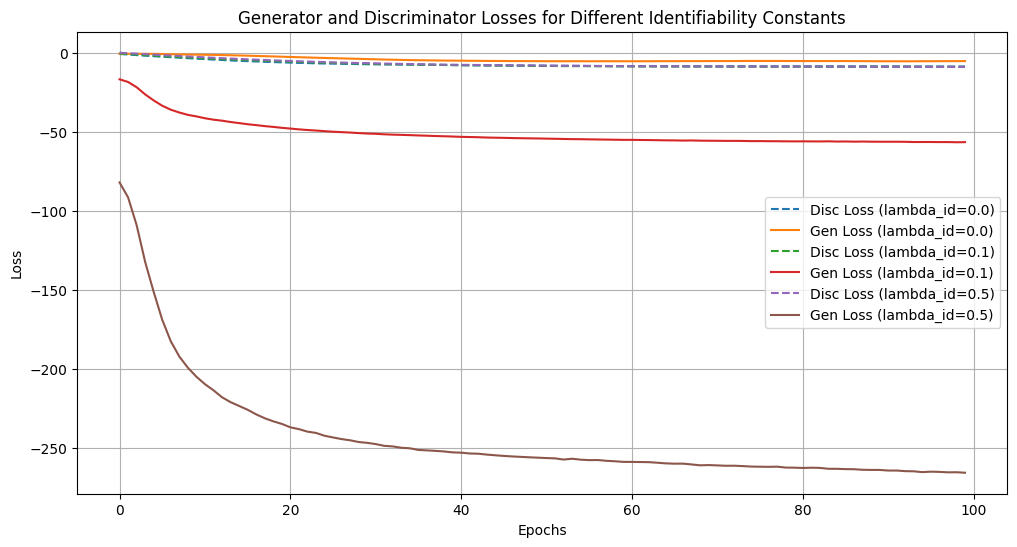

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


# -----------------------------------
# Identifiability Loss Definition
# -----------------------------------
def identifiability_loss(real_data, fake_data, lambda_identify, weight_tensor):
    # Calculate L2 norm of weighted difference between real and fake features
    norm = torch.norm(weight_tensor.to(real_data.device) * (real_data - fake_data), dim=1)
    return -(lambda_identify * norm.mean())


# -----------------------------------
# Gradient Penalty (Assuming you have already defined this)
# -----------------------------------
def gradient_penalty(discriminator, real_data, fake_data, lambda_gp=50):
    batch_size = real_data.size(0)
    alpha = torch.rand(batch_size, 1, device=real_data.device)
    alpha = alpha.expand_as(real_data)

    interpolated = alpha * real_data + (1 - alpha) * fake_data
    interpolated.requires_grad_(True)

    pred = discriminator(interpolated)
    gradients = torch.autograd.grad(
        outputs=pred,
        inputs=interpolated,
        grad_outputs=torch.ones_like(pred),
        create_graph=True,
        retain_graph=True,
    )[0]

    gradients = gradients.view(batch_size, -1)
    gradient_norm = gradients.norm(2, dim=1)

    return lambda_gp * ((gradient_norm - 1) ** 2).mean()


# -----------------------------------
# Train Function with Identifiability Loss
# -----------------------------------
def train_ads_gan(generator, discriminator, data, weight_tensor, epochs=50, batch_size=1024, latent_dim=256,
                  lambda_gp=5, n_critic=5, lambda_identify=0.0, device="cuda", lr_gen=1e-3, lr_disc=1e-6, beta1=0.5, beta2=0.999):
    generator = generator.to(device)
    discriminator = discriminator.to(device)
    gen_optimizer = optim.Adam(generator.parameters(), lr=lr_gen, betas=(beta1, beta2))
    disc_optimizer = optim.Adam(discriminator.parameters(), lr=lr_disc, betas=(beta1, beta2))

    dataset = TensorDataset(data)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)

    g_losses = []
    d_losses = []
    tau = 0.5  # Temperature for Gumbel Softmax

    for epoch in range(epochs):
        epoch_g_loss = 0
        epoch_d_loss = 0

        for batch_idx, real_batch in enumerate(dataloader):
            real_data = real_batch[0].to(device)

            # --------------------------------------
            # Train Discriminator (Critic)
            # --------------------------------------
            for _ in range(n_critic):
                z = torch.randn(real_data.size(0), latent_dim, device=device)
                fake_continuous, fake_categorical_logits = generator(z)
                fake_categorical_samples = [F.gumbel_softmax(logits, tau=tau, hard=True) for logits in fake_categorical_logits]
                fake_data = torch.cat([fake_continuous] + fake_categorical_samples, dim=1)

                disc_real = discriminator(real_data).mean()
                disc_fake = discriminator(fake_data.detach()).mean()

                gp = gradient_penalty(discriminator, real_data, fake_data.detach(), lambda_gp=lambda_gp)
                disc_loss = disc_fake - disc_real + gp

                disc_optimizer.zero_grad()
                disc_loss.backward()
                disc_optimizer.step()

            # --------------------------------------
            # Train Generator
            # --------------------------------------
            z = torch.randn(real_data.size(0), latent_dim, device=device)
            z = z + torch.normal(0, 0.2, size=z.shape, device=z.device)
            fake_continuous, fake_categorical_logits = generator(z)
            fake_categorical_samples = [F.gumbel_softmax(logits, tau=tau, hard=True) for logits in fake_categorical_logits]
            fake_data = torch.cat([fake_continuous] + fake_categorical_samples, dim=1)

            disc_fake = discriminator(fake_data).mean()
            # Original generator loss
            generator_loss = -disc_fake

            # Add identifiability loss
            identify_loss = identifiability_loss(real_data, fake_data, lambda_identify, weight_tensor)
            total_generator_loss = generator_loss + identify_loss

            gen_optimizer.zero_grad()
            total_generator_loss.backward()
            torch.nn.utils.clip_grad_norm_(generator.parameters(), max_norm=1.0)
            gen_optimizer.step()

            epoch_g_loss += total_generator_loss.item()
            epoch_d_loss += disc_loss.item()

        g_losses.append(epoch_g_loss / len(dataloader))
        d_losses.append(epoch_d_loss / (len(dataloader) * n_critic))

        print(
            f"Epoch {epoch + 1}/{epochs} | Discriminator Loss: {d_losses[-1]:.4f}, "
            f"Generator Loss: {g_losses[-1]:.4f} | lambda_identify={lambda_identify}"
        )
    return g_losses, d_losses


# -----------------------------------
# Assume that before this code snippet you have:
# 1. Defined your Generator and Discriminator classes
# 2. Computed 'data_tensor', 'continuous_dim', 'categorical_sizes_list', and 'latent_dim'
# 3. Computed 'device' and other variables
#
# Now we define weight_tensor before training:
# -----------------------------------

# Compute weight_tensor for identifiability loss
weight_tensor = torch.zeros(data_tensor.shape[1])
for i in range(data_tensor.shape[1]):
    feature_data = data_tensor[:, i]
    unique_values, counts = torch.unique(feature_data, return_counts=True)
    entropy = -torch.sum((counts / counts.sum()) * torch.log2(counts / counts.sum()))
    weight_tensor[i] = 1 / entropy

# -----------------------------------
# Running Multiple Trainings with Different Identifiability Weights
# -----------------------------------
identifiability_constants = [0.0, 0.1, 0.5]

all_g_losses = {}
all_d_losses = {}

for lam_id in identifiability_constants:
    # Re-initialize models
    generator = Generator(input_dim=latent_dim, continuous_dim=continuous_dim, categorical_sizes=categorical_sizes_list)
    discriminator = Discriminator(feature_dim=(continuous_dim + sum(categorical_sizes_list)))

    print(f"\nTraining with lambda_identify = {lam_id}")
    g_losses, d_losses = train_ads_gan(
        generator=generator,
        discriminator=discriminator,
        data=data_tensor.to(device),
        weight_tensor=weight_tensor,
        epochs=100,             # Adjust as needed
        batch_size=1024,
        latent_dim=latent_dim,
        lambda_gp=20,
        n_critic=5,
        lambda_identify=lam_id,
        device=device,
        lr_gen=1e-5,
        lr_disc=1e-6,
        beta1=0.5,
        beta2=0.999
    )

    all_g_losses[lam_id] = g_losses
    all_d_losses[lam_id] = d_losses

# -----------------------------------
# Plotting Results for Comparison
# -----------------------------------
plt.figure(figsize=(12, 6))
for lam_id in identifiability_constants:
    plt.plot(all_d_losses[lam_id], label=f'Disc Loss (lambda_id={lam_id})', linestyle='--')
    plt.plot(all_g_losses[lam_id], label=f'Gen Loss (lambda_id={lam_id})')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Generator and Discriminator Losses for Different Identifiability Constants')
plt.legend()
plt.grid(True)
plt.show()


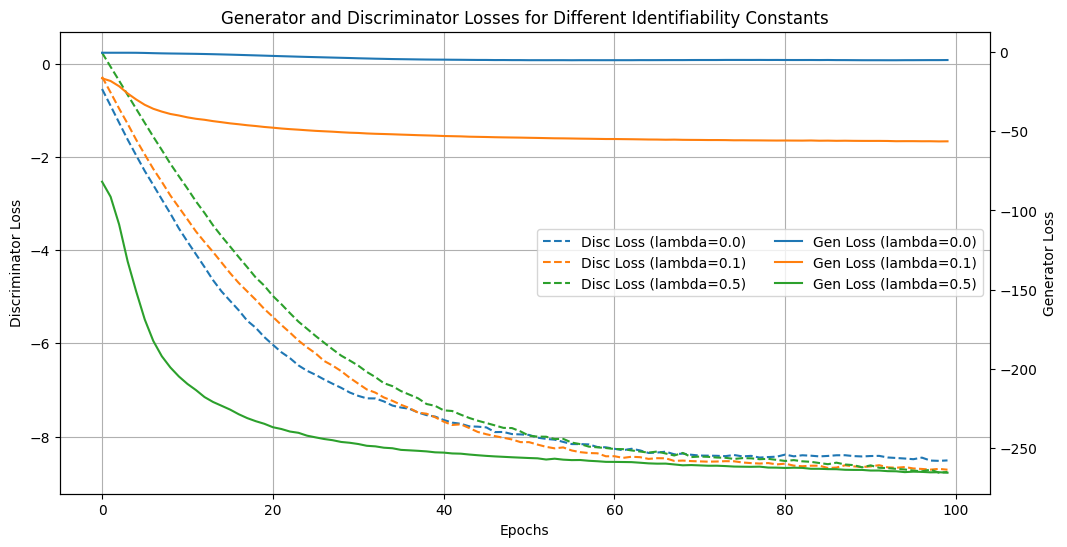

In [8]:
plt.figure(figsize=(12, 6))

# We'll first plot the discriminator losses on the left y-axis
ax1 = plt.gca()  # Get current axes
for lam_id in identifiability_constants:
    ax1.plot(all_d_losses[lam_id], label=f'Disc Loss (lambda={lam_id})', linestyle='--')

ax1.set_xlabel('Epochs')
ax1.set_ylabel('Discriminator Loss')
ax1.grid(True)

# Now create a twin axes that shares the same x-axis but will have a separate y-axis
ax2 = ax1.twinx()
for lam_id in identifiability_constants:
    ax2.plot(all_g_losses[lam_id], label=f'Gen Loss (lambda={lam_id})')

ax2.set_ylabel('Generator Loss')

# Combine legends
# One approach is to gather handles and labels from both axes
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(handles1 + handles2, labels1 + labels2, loc='center right', ncol=2)

plt.title('Generator and Discriminator Losses for Different Identifiability Constants')
plt.show()


<ipython-input-9-cf77523df759>:15: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(real_los, label='Real', shade=True, color='mediumspringgreen')
<ipython-input-9-cf77523df759>:16: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(synthetic_los, label='Synthetic', shade=True, color='slateblue')


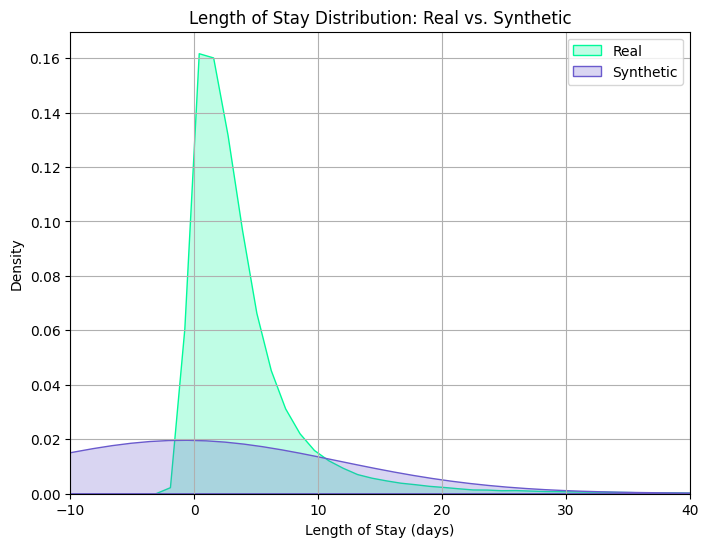

In [9]:
# For length_of_stay comparison:
# If you scaled length_of_stay before using 'scaler',
# you can inverse transform it to get the original scale.

real_los_scaled = real_data_features['length_of_stay']
synthetic_los_scaled = synthetic_df['length_of_stay']

# Inverse transform the scaled values back to the original scale
real_los = scaler.inverse_transform(real_los_scaled.values.reshape(-1, 1)).flatten()
synthetic_los = scaler.inverse_transform(synthetic_los_scaled.values.reshape(-1, 1)).flatten()

plt.figure(figsize=(8,6))

# Plot KDE of both distributions on the same plot
sns.kdeplot(real_los, label='Real', shade=True, color='mediumspringgreen')
sns.kdeplot(synthetic_los, label='Synthetic', shade=True, color='slateblue')

plt.title('Length of Stay Distribution: Real vs. Synthetic')
plt.xlabel('Length of Stay (days)')
plt.xlim(-10,40)
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()
